# Group 14 - Project FP01
## Time series anomaly detection - RNN-EBM

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from dataset import *
from plots import *
from metrics import *

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [4]:

#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

# COLLISION LABEL
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp_v2.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')

collisions_adjusted_rec_1 = collision_rec1.Timestamp - pd.to_timedelta([2] * len(collision_rec1.Timestamp), 'h')
collision_rec1['Timestamp'] = collisions_adjusted_rec_1
collisions_init1 = collision_rec1[collision_rec1['Inizio/fine'] == "i"].Timestamp

collision_rec5 = pd.read_excel(xls, 'rec5')
collisions_adjusted_rec_5 = collision_rec5.Timestamp - pd.to_timedelta([2] * len(collision_rec5.Timestamp), 'h')
collision_rec5['Timestamp'] = collisions_adjusted_rec_5
collisions_init5 = collision_rec5[collision_rec5['Inizio/fine'] == "i"].Timestamp

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



In [5]:
collisions

,Inizio/fine,Timestamp
0,i,2022-08-11 14:02:17.450
1,f,2022-08-11 14:02:21.460
2,i,2022-08-11 14:02:28.320
3,f,2022-08-11 14:02:31.420
4,i,2022-08-11 14:02:45.770
...,...,...
135,f,2022-08-11 17:09:28.580
136,i,2022-08-11 17:09:38.750
137,f,2022-08-11 17:09:42.830
138,i,2022-08-11 17:09:53.950


In [6]:
collision_rec1

,Inizio/fine,Timestamp
0,i,2022-08-11 14:02:17.450
1,f,2022-08-11 14:02:21.460
2,i,2022-08-11 14:02:28.320
3,f,2022-08-11 14:02:31.420
4,i,2022-08-11 14:02:45.770
...,...,...
69,f,2022-08-11 14:28:39.970
70,i,2022-08-11 14:29:17.140
71,f,2022-08-11 14:29:19.660
72,i,2022-08-11 14:29:41.210


In [7]:
collision_rec5

,Inizio/fine,Timestamp
0,i,2022-08-11 16:44:43.810
1,f,2022-08-11 16:44:46.220
2,i,2022-08-11 16:44:56.230
3,f,2022-08-11 16:45:00.440
4,i,2022-08-11 16:45:11.420
...,...,...
135,f,2022-08-11 17:09:28.580
136,i,2022-08-11 17:09:38.750
137,f,2022-08-11 17:09:42.830
138,i,2022-08-11 17:09:53.950


In [8]:
collisions_init

0     2022-08-11 14:02:17.450
2     2022-08-11 14:02:28.320
4     2022-08-11 14:02:45.770
6     2022-08-11 14:02:57.490
8     2022-08-11 14:03:56.960
                ...          
130   2022-08-11 17:08:45.460
132   2022-08-11 17:09:10.160
134   2022-08-11 17:09:24.380
136   2022-08-11 17:09:38.750
138   2022-08-11 17:09:53.950
Name: Timestamp, Length: 107, dtype: datetime64[ns]

### Features Exctraction

In [9]:
start_time = time.time()
frequency = 1/float(freq)
print(frequency)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int, save_dir="../features/df_features/RNN_EBM/")
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision, save_dir="../features/df_features_collisions/RNN_EBM/")
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1, save_dir="../features/df_features_collisions_1/RNN_EBM/")
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5, save_dir="../features/df_features_collisions_5/RNN_EBM/")
print("--- %s seconds ---" % (time.time() - start_time))

10.0
Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Features saved to ../features/df_features/RNN_EBM/features_statistical_10.0.csv.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Features saved to ../features/df_features_collisions/RNN_EBM/features_statistical_10.0.csv.
Computing features.


Features saved to ../features/df_features_collisions_1/RNN_EBM/features_statistical_10.0.csv.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Features saved to ../features/df_features_collisions_5/RNN_EBM/features_statistical_10.0.csv.
--- 157.27570962905884 seconds ---


In [10]:
collisions_zones = find_collisions_zones(collisions)
collisions_zones_1 = find_collisions_zones(collision_rec1)
collisions_zones_5 = find_collisions_zones(collision_rec5)

In [11]:
X_train, y_train, X_test, y_test, X_test_start_end = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1, X_test_start_end1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5,  X_test_start_end5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

In [12]:
def label_collision_data(df_features, collisions_init):
# Create a binary label column initialized to 0 (no collision)
    df_features['is_collision'] = 0

    # Iterate over each collision interval
    for collision_time in collisions_init:
        mask = (df_features['start'] <= collision_time) & (df_features['end'] >= collision_time)
        
        df_features.loc[mask, 'is_collision'] = 1

    return df_features

In [13]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
df_with_labels_1 = label_collision_data(df_features_collision_1, collisions_init1)
df_with_labels_5 = label_collision_data(df_features_collision_5, collisions_init5)

In [14]:
y_collision = df_with_labels['is_collision']
y_collision_1 = df_with_labels_1['is_collision']
y_collision_5 = df_with_labels_5['is_collision']

In [15]:
df_features_collision.drop(columns=['is_collision'], inplace=True)
df_features_collision_1.drop(columns=['is_collision'], inplace=True)
df_features_collision_5.drop(columns=['is_collision'], inplace=True)

In [16]:
collisions_init1

0    2022-08-11 14:02:17.450
2    2022-08-11 14:02:28.320
4    2022-08-11 14:02:45.770
6    2022-08-11 14:02:57.490
8    2022-08-11 14:03:56.960
10   2022-08-11 14:04:09.870
12   2022-08-11 14:04:23.030
14   2022-08-11 14:04:38.700
16   2022-08-11 14:04:59.980
18   2022-08-11 14:05:24.370
20   2022-08-11 14:12:46.120
22   2022-08-11 14:12:59.320
24   2022-08-11 14:13:23.940
26   2022-08-11 14:14:31.680
28   2022-08-11 14:14:41.650
30   2022-08-11 14:15:48.530
32   2022-08-11 14:17:04.230
34   2022-08-11 14:17:44.560
36   2022-08-11 14:18:18.700
38   2022-08-11 14:19:36.680
40   2022-08-11 14:20:38.480
42   2022-08-11 14:20:58.360
44   2022-08-11 14:21:05.460
46   2022-08-11 14:23:29.050
48   2022-08-11 14:23:50.210
50   2022-08-11 14:23:55.660
52   2022-08-11 14:24:22.910
54   2022-08-11 14:25:06.440
56   2022-08-11 14:25:33.600
58   2022-08-11 14:25:58.580
60   2022-08-11 14:27:29.460
62   2022-08-11 14:27:45.230
64   2022-08-11 14:27:55.520
66   2022-08-11 14:28:07.180
68   2022-08-1

In [17]:
np.count_nonzero(y_collision), np.count_nonzero(y_collision_1), np.count_nonzero(y_collision_5)

(105, 35, 70)

## RNN-EBM


In [18]:
from algorithms.rnn_ebm import RecurrentEBM

# Disable eager execution
tf.compat.v1.disable_eager_execution()

classifier = RecurrentEBM(
    num_epochs=1000,
    n_hidden=64,
    n_hidden_recurrent=128,
    min_lr=1e-4,
    min_energy=None,  # We'll set this to None initially and determine it after training
    batch_size=64,
    seed=42,
    gpu=None  # Set to None for CPU, or specify GPU index if available
)
# Train the RNN on normal data
classifier.fit(X_train)
print("RNN-EBM training completed.")


100%|██████████| 1000/1000 [02:11<00:00,  7.60it/s]

RNN-EBM training completed.


In [19]:
y_test_predict = classifier.predict(X_test)

In [20]:
len(y_test_predict)

306

In [21]:
anomaly_scores = predict_anomaly_score(X_test, classifier)
anomaly_scores1 = predict_anomaly_score(X_test1, classifier)
anomaly_scores5 = predict_anomaly_score(X_test5, classifier)

Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [22]:
len(anomaly_scores), len(anomaly_scores1), len(anomaly_scores5)

(306, 164, 141)

In [23]:
thresholds = compute_various_thresholds(anomaly_scores)
thresholds_1 = compute_various_thresholds(anomaly_scores1)
thresholds_5 = compute_various_thresholds(anomaly_scores5)

Number of anomalies detected: 7 with threshold 387.45668029785156, std
Number of anomalies detected: 116 with threshold 42.494882583618164, mad
Number of anomalies detected: 16 with threshold 260.24925231933594, percentile
Number of anomalies detected: 7 with threshold 373.5731496810913, IQR

Number of anomalies detected: 6 with threshold 276.96828842163086, std
Number of anomalies detected: 48 with threshold 26.592960357666016, mad
Number of anomalies detected: 9 with threshold 220.33651351928708, percentile
Number of anomalies detected: 20 with threshold 75.02653586864471, IQR

Number of anomalies detected: 3 with threshold 400.3830108642578, std
Number of anomalies detected: 3 with threshold 366.7615661621094, mad
Number of anomalies detected: 8 with threshold 260.9263000488281, percentile
Number of anomalies detected: 3 with threshold 462.6150255203247, IQR



### Anomaly Detection

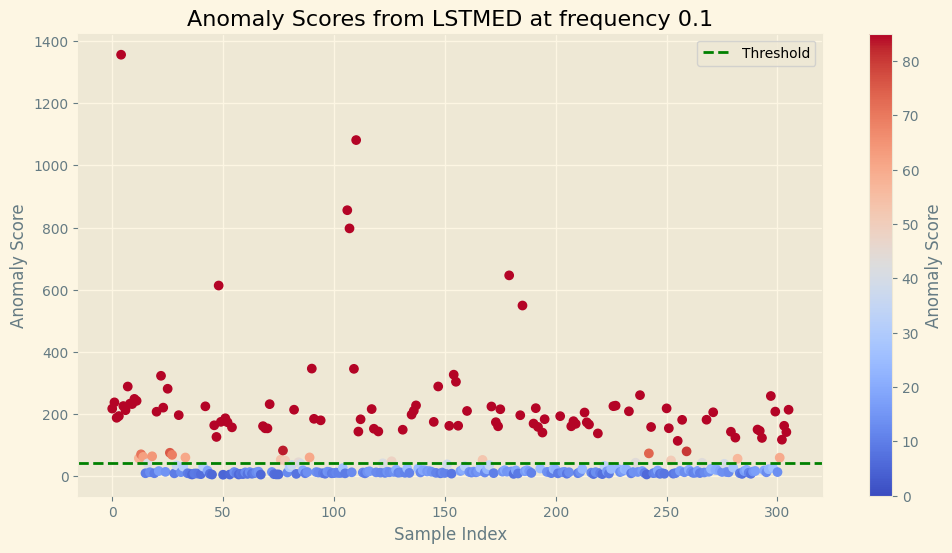

Number of anomalies detected: 116


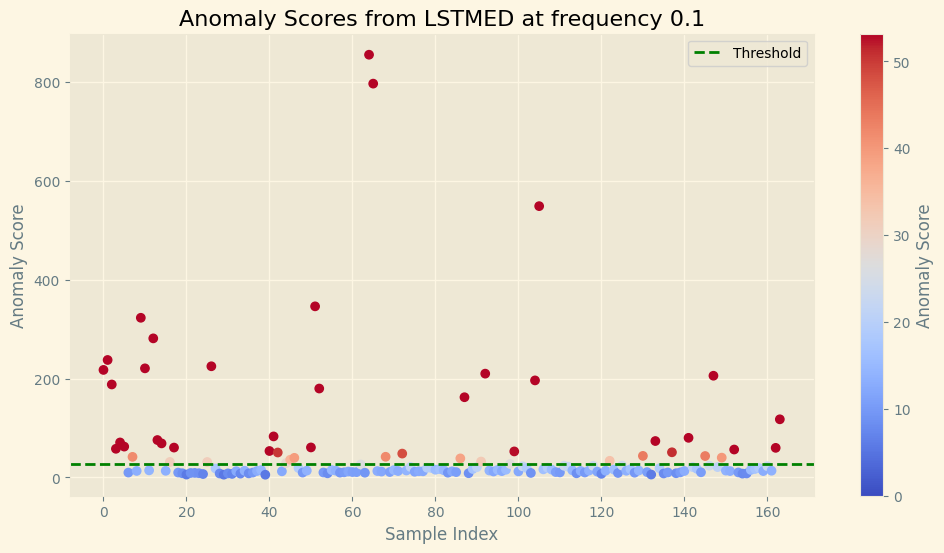

Number of anomalies detected: 48


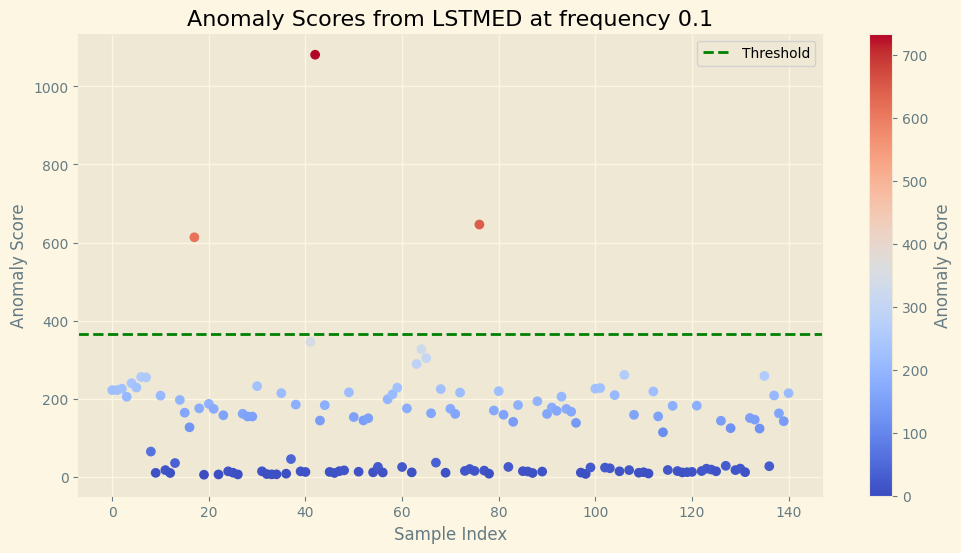

Number of anomalies detected: 3


In [24]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, thresholds[1])
anomalies_detected1 = plot_anomalies(anomaly_scores1, freq, thresholds_1[1])
anomalies_detected5 = plot_anomalies(anomaly_scores5, freq, thresholds_5[1]/4)

In [25]:
def compute_metrics(anomaly_scores, y_test, threshold):
    
    print(f"Threshold: {threshold:.4f}")
    
    roc_auc = roc_auc_score(y_test, anomaly_scores)

    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    # Calculate F1 score
    f1 = f1_score(y_test, anomaly_scores > threshold)
    print(f"F1 Score: {f1:.4f}")
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, anomaly_scores > threshold)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Calculate precision
    precision = precision_score(y_test, anomaly_scores > threshold)
    print(f"Precision: {precision:.4f}")
    
    # Calculate recall
    recall = recall_score(y_test, anomaly_scores > threshold)
    print(f"Recall: {recall:.4f}")
    
    print(classification_report(y_test, anomaly_scores > threshold))

In [29]:
compute_metrics(anomaly_scores, y_collision, thresholds[1])
print("############################################")
compute_metrics(anomaly_scores1, y_collision_1, thresholds_1[1])
print("############################################")
compute_metrics(anomaly_scores5, y_collision_5, thresholds_5[1]/4)

Threshold: 42.4949
ROC AUC Score: 0.9482
F1 Score: 0.9050
Accuracy: 0.9314
Precision: 0.8621
Recall: 0.9524
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       201
           1       0.86      0.95      0.90       105

    accuracy                           0.93       306
   macro avg       0.92      0.94      0.93       306
weighted avg       0.94      0.93      0.93       306

############################################
Threshold: 26.5930
ROC AUC Score: 0.9741
F1 Score: 0.8434
Accuracy: 0.9207
Precision: 0.7292
Recall: 1.0000
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       129
           1       0.73      1.00      0.84        35

    accuracy                           0.92       164
   macro avg       0.86      0.95      0.90       164
weighted avg       0.94      0.92      0.92       164

############################################
Threshold: 91.6904
ROC AUC Score: 0.9074

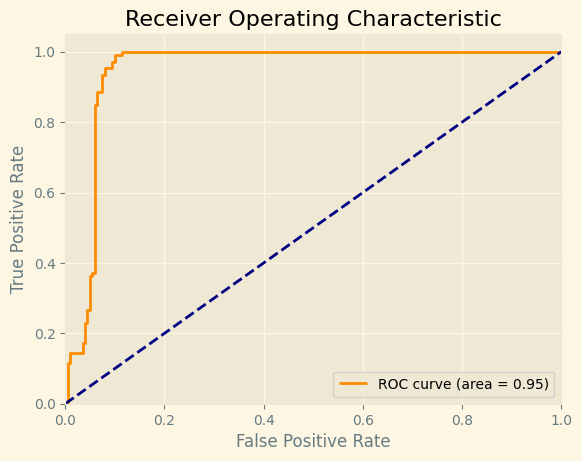

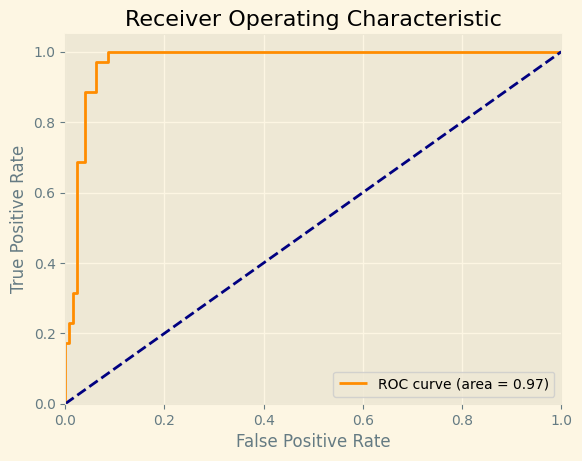

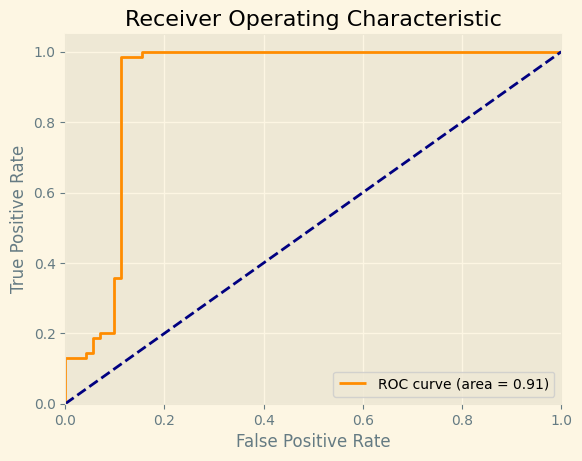

In [27]:
plot_roc_curve(y_collision, anomaly_scores)
plot_roc_curve(y_collision_1, anomaly_scores1)
plot_roc_curve(y_collision_5, anomaly_scores5)

## Map anomalies to original time series

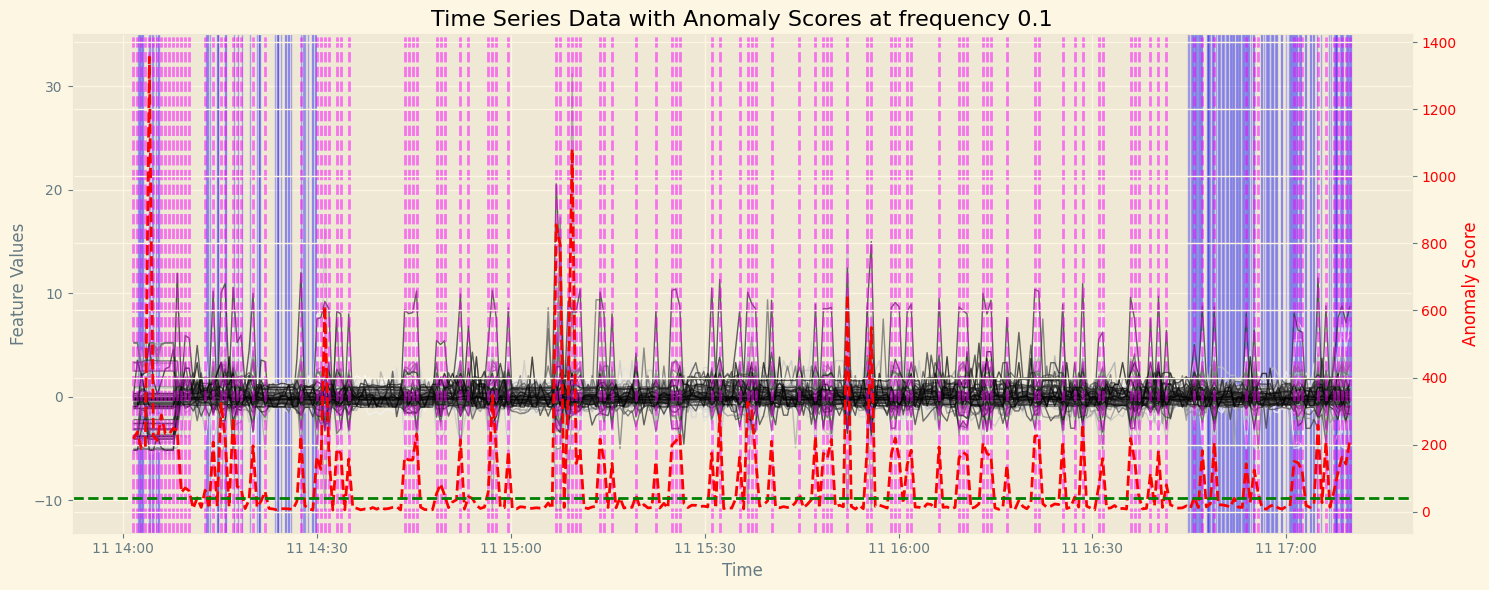

Top 116 Anomalies:
                        timestamp  anomaly_score  \
4   2022-08-11 14:04:02.788550819    1355.636230   
110 2022-08-11 15:09:28.619147540    1081.190552   
106 2022-08-11 15:07:00.474596721     855.662354   
107 2022-08-11 15:07:37.510734426     797.158081   
179 2022-08-11 15:52:04.112649180     646.098022   
..                            ...            ...   
78  2022-08-11 14:49:43.462740983      50.477894   
126 2022-08-11 15:19:21.197350819      48.259392   
84  2022-08-11 14:53:25.679567213      45.170017   
236 2022-08-11 16:27:15.172498360      43.601376   
266 2022-08-11 16:45:46.256629508      43.330589   

     machine_nameKuka Robot_apparent_power-_Average power  \
4                                            -5.323114      
110                                          -0.911260      
106                                          -1.885449      
107                                          -1.181816      
179                                          -1.338

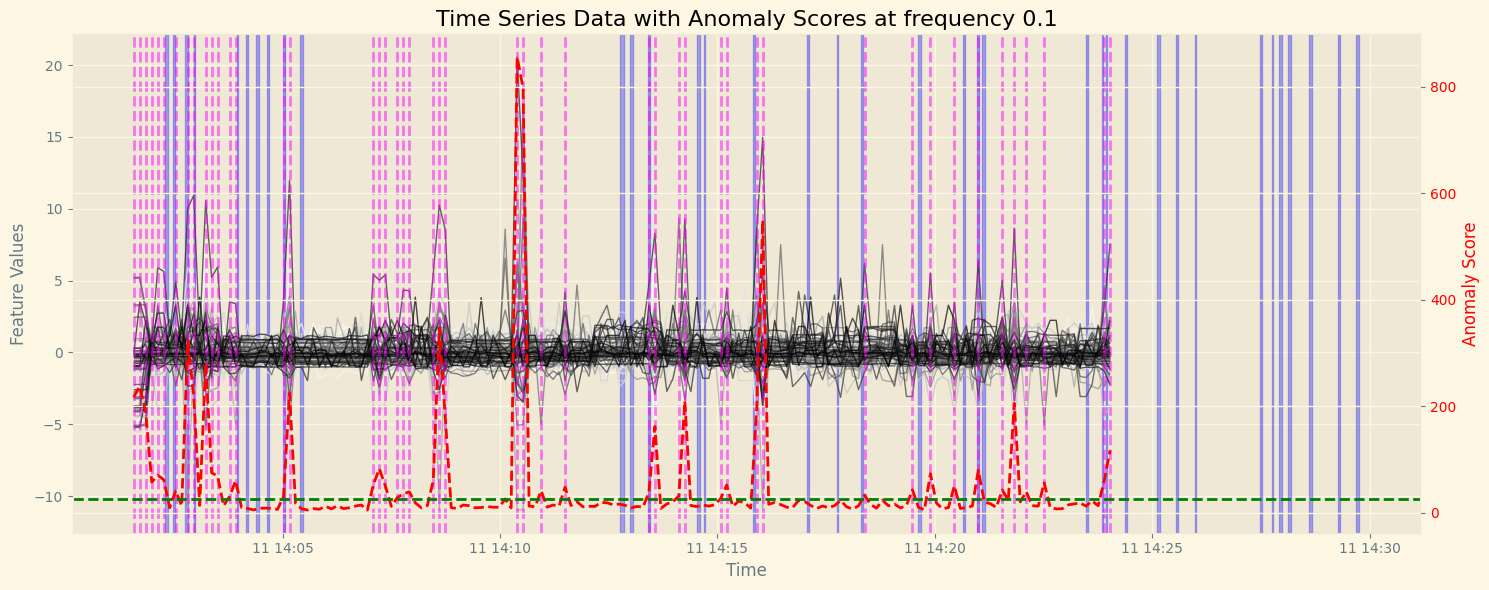

Top 48 Anomalies:
                  timestamp  anomaly_score  \
64  2022-08-11 14:10:23.668     855.662354   
65  2022-08-11 14:10:31.934     797.158081   
105 2022-08-11 14:16:02.574     549.168823   
51  2022-08-11 14:08:36.210     346.334900   
9   2022-08-11 14:02:49.038     323.166321   
12  2022-08-11 14:03:13.836     281.497742   
1   2022-08-11 14:01:42.910     237.746429   
26  2022-08-11 14:05:09.560     225.020508   
10  2022-08-11 14:02:57.304     220.814133   
0   2022-08-11 14:01:34.644     217.630005   
92  2022-08-11 14:14:15.116     210.081909   
147 2022-08-11 14:21:49.746     205.859650   
104 2022-08-11 14:15:54.308     196.411560   
2   2022-08-11 14:01:51.176     188.166763   
52  2022-08-11 14:08:44.476     179.959839   
87  2022-08-11 14:13:33.786     162.335541   
163 2022-08-11 14:24:02.002     117.667831   
41  2022-08-11 14:07:13.550      83.020752   
141 2022-08-11 14:21:00.150      80.159843   
13  2022-08-11 14:03:22.102      75.684425   
133 2022-08-11 1

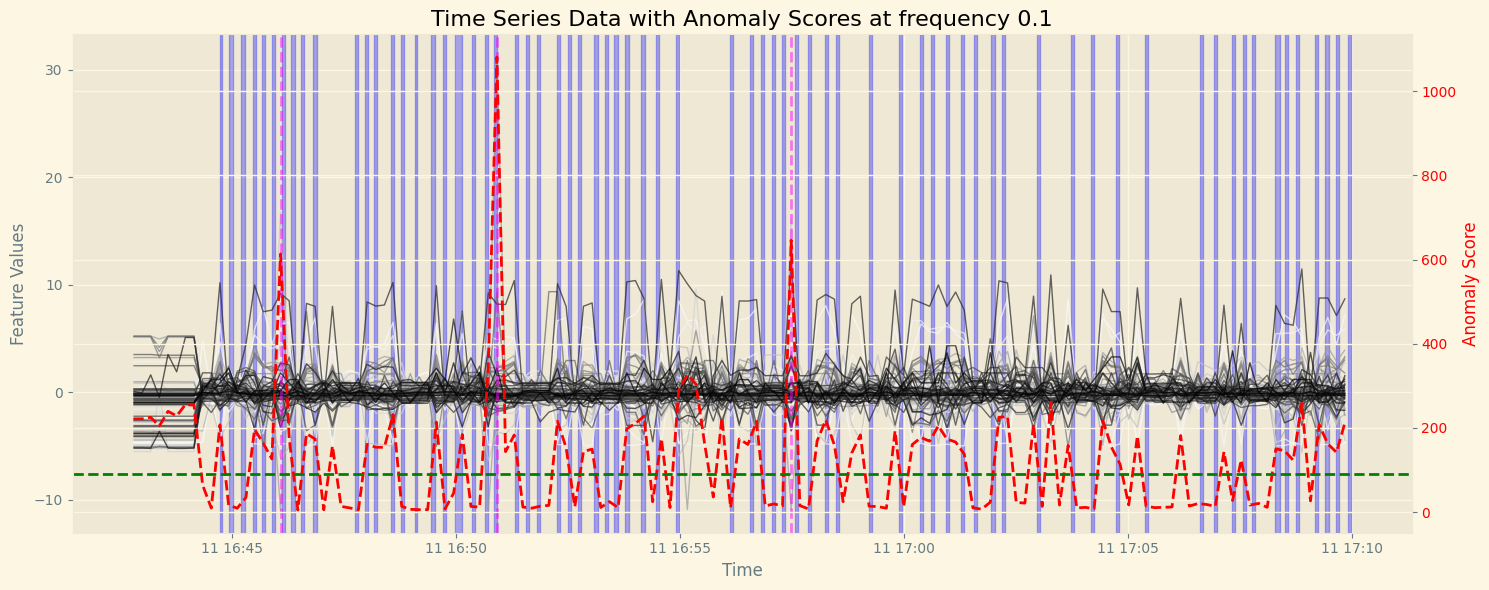

Top 3 Anomalies:
                       timestamp  anomaly_score  \
42 2022-08-11 16:50:54.503700000    1081.190552   
76 2022-08-11 16:57:28.682457142     646.098022   
17 2022-08-11 16:46:04.666378571     613.458984   

    machine_nameKuka Robot_apparent_power-_Average power  \
42                                          -0.911260      
76                                          -1.338344      
17                                          -0.707436      

    machine_nameKuka Robot_apparent_power-_Variance  \
42                                         0.246879   
76                                         0.201584   
17                                         1.403391   

    machine_nameKuka Robot_current-_Min  \
42                             0.235311   
76                            -0.957586   
17                             0.300387   

    machine_nameKuka Robot_phase_angle-_Average power  \
42                                          -1.270309   
76                           

In [28]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq, thresholds[1], collisions_zones , X_test_start_end)
plot_anomalies_over_time(X_test1, anomaly_scores1, anomalies_detected1, freq, thresholds_1[1], collisions_zones_1, X_test_start_end1)
plot_anomalies_over_time(X_test5, anomaly_scores5, anomalies_detected5, freq, thresholds_5[1]/4, collisions_zones_5, X_test_start_end5)